# HOMEWORK 4 - APPLIED ML

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import networkx as nx
import itertools
import sys

## 1. Propensity score matching

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [2]:
#loading data
lalonde_df = pd.read_csv('lalonde.csv').set_index('id')
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We are going to increase the dataset

In [3]:
def ethnicity_text(row):
    if row["black"] == 1:
        return "black"
    elif row["hispan"] == 1:
        return "hispanic"
    else:
        return "white"

def ethnicity_white(row):
    if row["ethnicity"] == "white":
        return 1
    else:
        return 0
    
lalonde_df["ethnicity"] = lalonde_df.apply(ethnicity_text, axis=1)
lalonde_df["white"] = lalonde_df.apply(ethnicity_white, axis=1)

### 1.1. A naive analysis

In [42]:
treated = lalonde_df.loc[lalonde_df['treat'] == 1]
not_treated = lalonde_df.loc[lalonde_df['treat'] == 0]

In [5]:
treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [6]:
not_treated['re78'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

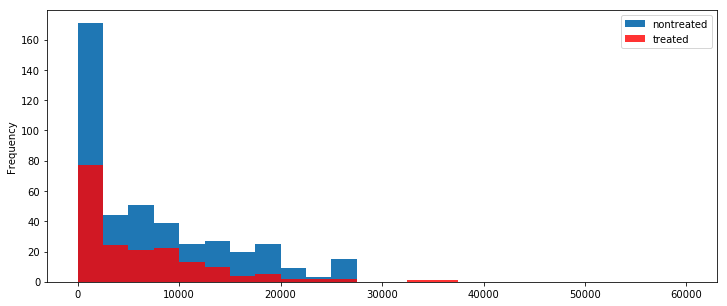

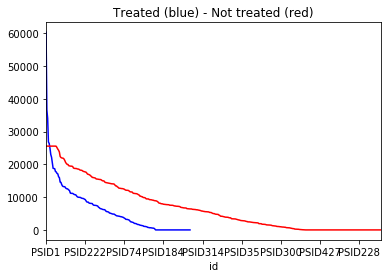

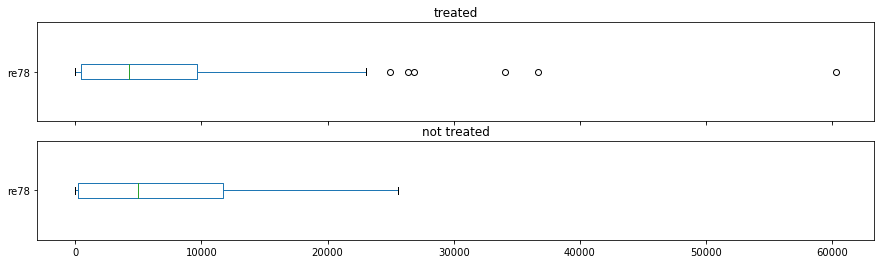

In [7]:
bins = np.linspace(0, 60000, 25)
#df2.hist(column="re78", by="treat", sharex=True, sharey=True, bins=bins, figsize=(12,5))
ax = not_treated["re78"].plot.hist(bins=bins, figsize=(12,5))
treated["re78"].plot.hist(bins=bins, ax=ax, alpha=0.8, color="red")
ax.legend(["nontreated", "treated"]);
plt.show()

plt.figure()
treated['re78'].sort_values(ascending=False).plot(color='blue', title='Treated (blue) - Not treated (red)')
not_treated['re78'].sort_values(ascending=False).plot(color='red')
plt.show()

plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,4), sharex=True)
axes[0].set_title("treated")
treated["re78"].plot(kind="box", vert=False, ax=axes[0])
axes[1].set_title("not treated")
not_treated["re78"].plot(kind="box", vert=False, ax=axes[1])
plt.show()


Here a naive "researcher" might conclude that the treatment doesn't work. As the average income of the not treated group is higher than the the one form the treated group. But he/she could also conclude that if you are part of the few *lucky* ones in the treated group, you will have a much higher income than the people which are not getting the training.

### 1.2. A closer look at the data

We will now compare the distribution of real income values but this time for each year, ages and education level. Comparing the 1/0 values of the ethnic, marriage and treatment does not make much sens.

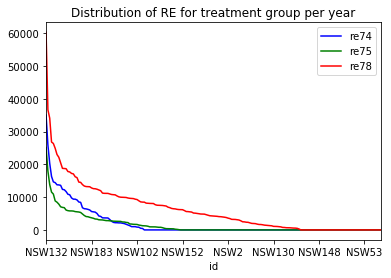

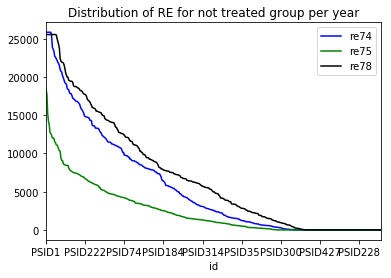

In [8]:
treated['re74'].sort_values(ascending=False).plot(color='blue', title='Distribution of RE for treatment group per year', legend=True)
treated['re75'].sort_values(ascending=False).plot(color='green', legend=True)
treated['re78'].sort_values(ascending=False).plot(color='red', legend=True)
plt.show()

not_treated['re74'].sort_values(ascending=False).plot(color='blue', title='Distribution of RE for not treated group per year', legend=True)
not_treated['re75'].sort_values(ascending=False).plot(color='green', legend=True)
not_treated['re78'].sort_values(ascending=False).plot(color='black', legend=True)
plt.show()

It would seem now (for the less naïve researcher) that the treatment actually works as we see the number of unemployed person (with real income = 0.0) decrease much faster in the treated group as in the other. To confirm this intuition let's print the amount of unemployed person in both groups.

In [9]:
print('Unemployed person in Treated group per year:\n',(treated[['re74', 're75', 're78']] == 0).astype(int).sum(axis=0))
print('Unemployed person in Not-treated group per year:\n',(not_treated[['re74', 're75', 're78']] == 0).astype(int).sum(axis=0))

Unemployed person in Treated group per year:
 re74    131
re75    111
re78     45
dtype: int64
Unemployed person in Not-treated group per year:
 re74    112
re75    134
re78     98
dtype: int64


Below, some functions to plot insights and aggregate about the the two groups

In [69]:
def split_re_variables_by_ethnicity(treated, nontreated, name, before=False):
    def build_df_for_graph(df):
        bins = np.linspace(0, 30000, 12)
        white = pd.cut(df[df["white"] == 1][name], bins, right=False).value_counts()
        hispan = pd.cut(df[df["hispan"] == 1][name], bins, right=False).value_counts()
        black = pd.cut(df[df["black"] == 1][name], bins, right=False).value_counts()
        
        df_tmp = pd.concat([white, hispan, black], axis=1).fillna(0)
        df_tmp.columns=["white", "hispan", "black"]
        
        df_tmp = df_tmp.T
        
        df_tmp.columns = list(map(lambda x: int(x.left), df_tmp.columns))
        
        df_tmp = df_tmp.T
        
        return df_tmp

    
    fig = plt.figure()
    fig.suptitle('{} by ethnicity'.format(name), fontsize=12)
    ax1  = fig.add_subplot(1, 2, 1)
    ax1.set_title("Non treated")
    ax2  = fig.add_subplot(1, 2, 2)
    ax2.set_title("Treated")
    
    treated_for_graph = build_df_for_graph(treated)
    nontreated_for_graph = build_df_for_graph(nontreated)
    
    nontreated_for_graph.plot.bar(stacked=True, ax=ax1)
    treated_for_graph.plot.bar(stacked=True, ax=ax2)
    
    if before:
        fig.suptitle("{} by ethnicity - Before".format(name))
    
    fig.set_figwidth(16)
    fig.set_figheight(3)
    plt.tight_layout()
    fig.set_figheight(3)
    plt.show()

def plot_ethnicity(treated, nontreated, before=False):
    non_treated_ethnic = pd.DataFrame(nontreated["ethnicity"].value_counts().sort_index())
    non_treated_ethnic.columns = ["nontreated"]
    treated_ethnic = pd.DataFrame(treated["ethnicity"].value_counts().sort_index())
    treated_ethnic.columns = ["treated"]

    df_tmp = pd.concat([non_treated_ethnic, treated_ethnic], axis=1)

    fig = plt.figure()
    ax1  = fig.add_subplot(1, 2, 1)
    ax1.set_title("Ethnicity (absolute numbers)")
    ax2  = fig.add_subplot(1, 2, 2)
    ax2.set_title("Ethnicity (ratio numbers)")

    df_tmp.T.plot.barh(stacked=True, ax=ax1)
    (df_tmp / df_tmp.sum(axis=0)).T.plot.barh(stacked=True, ax=ax2)
    
    if before:
        fig.suptitle("Before")
    
    fig.set_figwidth(8)
    fig.set_figheight(3)
    plt.tight_layout()
    
    plt.show()
    
def plot_married(treated, nontreated, before=False):
    non_treated_ethnic = pd.DataFrame(nontreated["married"].value_counts().sort_index())
    non_treated_ethnic.columns = ["nontreated"]
    treated_ethnic = pd.DataFrame(treated["married"].value_counts().sort_index())
    treated_ethnic.columns = ["treated"]

    df_tmp = pd.concat([non_treated_ethnic, treated_ethnic], axis=1)

    fig = plt.figure()
    ax1  = fig.add_subplot(1, 2, 1)
    ax1.set_title("Married (absolute numbers)")
    ax2  = fig.add_subplot(1, 2, 2)
    ax2.set_title("Married (ratio numbers)")

    df_tmp.T.plot.barh(stacked=True, ax=ax1)
    (df_tmp / df_tmp.sum(axis=0)).T.plot.barh(stacked=True, ax=ax2)

    ax1.legend(["Not married", "Married"])
    ax2.legend(["Not married", "Married"])
    
    if before:
        fig.suptitle("Before")

    fig.set_figwidth(8)
    fig.set_figheight(3)
    plt.tight_layout()
    
    
    plt.show()
    
    
def plot_nodegree(treated, nontreated, before=False):
    non_treated_ethnic = pd.DataFrame(nontreated["nodegree"].value_counts().sort_index())
    non_treated_ethnic.columns = ["nontreated"]
    treated_ethnic = pd.DataFrame(treated["nodegree"].value_counts().sort_index())
    treated_ethnic.columns = ["treated"]

    df_tmp = pd.concat([non_treated_ethnic, treated_ethnic], axis=1)

    fig = plt.figure()
    ax1  = fig.add_subplot(1, 2, 1)
    ax1.set_title("Degree (absolute numbers)")
    ax2  = fig.add_subplot(1, 2, 2)
    ax2.set_title("Degree (ratio numbers)")

    df_tmp.T.plot.barh(stacked=True, ax=ax1)
    (df_tmp / df_tmp.sum(axis=0)).T.plot.barh(stacked=True, ax=ax2)

    ax1.legend(["No degree", "Degree"])
    ax2.legend(["No degree", "Degree"])
    
    if before:
        fig.suptitle("Before")

    fig.set_figwidth(8)
    fig.set_figheight(3)
    plt.tight_layout()
    plt.show()
    
def plot_stats_about_age_and_eduction(treated, nontreated, before=False):
    fig = plt.figure(figsize=(2, 5))
    bins_age = np.linspace(0, 55, 12)
    bins_education = np.linspace(0, 18, 18)

    columns = 2

    ax4  = fig.add_subplot(columns, 2, 1)
    ax5  = fig.add_subplot(columns, 2, 3)

    ax12 = fig.add_subplot(columns, 2, 2, sharey=ax4)
    ax13 = fig.add_subplot(columns, 2, 4, sharey=ax5)

    nontreated["age"].plot.hist(bins=bins_age, ax=ax4)
    nontreated["educ"].plot.hist(bins=bins_education, ax=ax5, color="red")

    treated["age"].plot.hist(bins=bins_age, ax=ax12)
    treated["educ"].plot.hist(bins=bins_education, ax=ax13, color="red")

    ax4.set_title("Age distribution")
    ax5.set_title("Years of education")
    
    if before:
        fig.suptitle("Before")

    fig.set_figheight(3)
    fig.set_figwidth(6)
    plt.tight_layout()
    plt.show()

def stats_about_dataset(treated, nontreated, compare_treated=None, compare_nontreated=None):
    if compare_treated is not None:
        split_re_variables_by_ethnicity(compare_treated, compare_nontreated, "re74", before=True)
    split_re_variables_by_ethnicity(treated, nontreated, "re74")
    
    if compare_treated is not None:
        split_re_variables_by_ethnicity(compare_treated, compare_nontreated, "re75", before=True)
    split_re_variables_by_ethnicity(treated, nontreated, "re75")
    
    if compare_treated is not None:
        split_re_variables_by_ethnicity(compare_treated, compare_nontreated, "re78", before=True)
    split_re_variables_by_ethnicity(treated, nontreated, "re78")
    
    if compare_treated is not None:
        plot_stats_about_age_and_eduction(compare_treated, compare_nontreated, before=True)
    plot_stats_about_age_and_eduction(treated, nontreated)

    if compare_treated is not None:
        plot_ethnicity(compare_treated, compare_nontreated, before=True)
    plot_ethnicity(treated, nontreated)
    
    if compare_treated is not None:
        plot_married(compare_treated, compare_nontreated, before=True)
    plot_married(treated, nontreated)
    
    if compare_treated is not None:
        plot_nodegree(compare_treated, compare_nontreated, before=True)
    plot_nodegree(treated, nontreated)

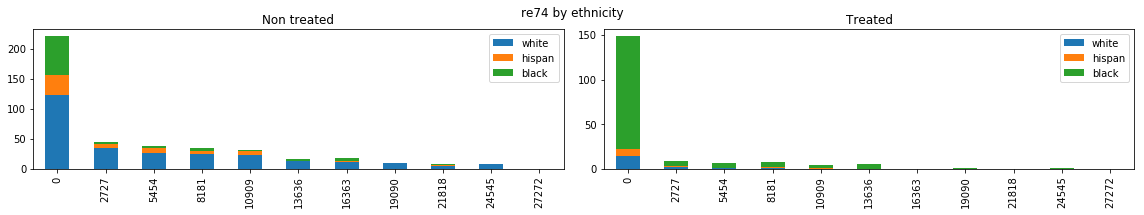

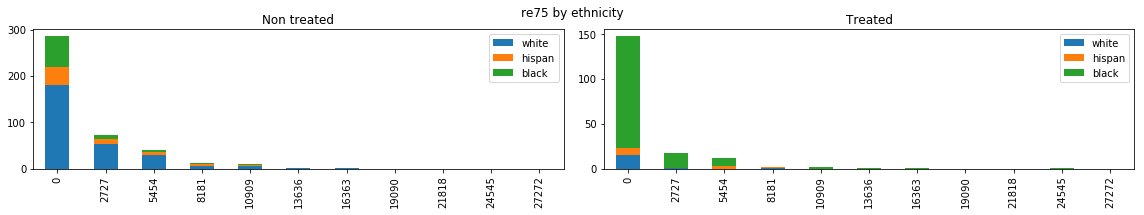

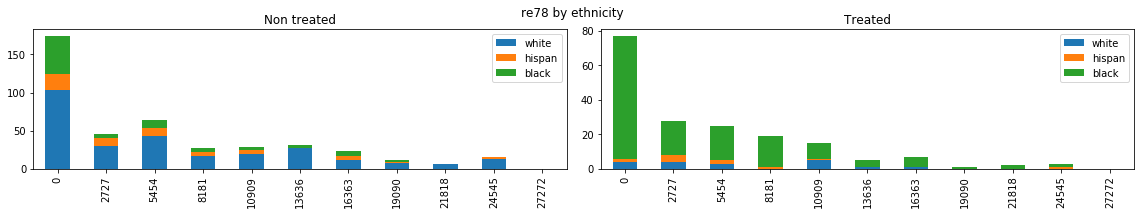

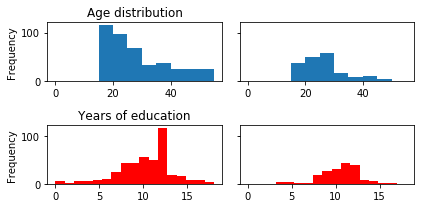

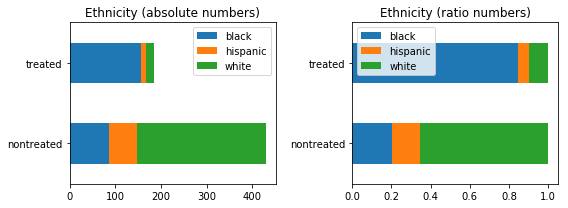

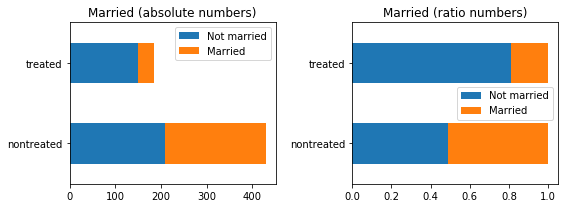

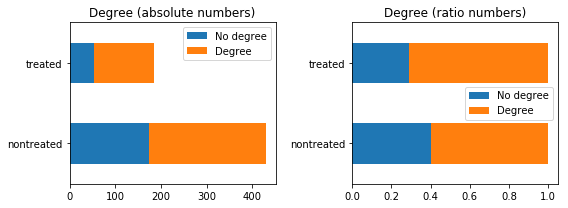

In [70]:
stats_about_dataset(treated, not_treated)

We can see that the revenues are not spread out the same way, identically for the ages. The years of education follow almost the same pattern, but only the non treated group has value at 0 year of education). Also Ethnicity is not represented the same way. There is a skew toward white people where we may guess that White people are not more representend in people who needs welfare.

We can conclude this section by saying that no, the two groups do not represent the same population.

### 1.3. A propensity score model

In [12]:
logistic = linear_model.LogisticRegression()
X = lalonde_df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
y = lalonde_df['treat']
#training logistic model
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Here is the propensity score (probability of belonging to the class 0 or 1)

In [13]:
prop_score = logistic.predict_proba(X)
prop_score

array([[ 0.55664958,  0.44335042],
       [ 0.85534047,  0.14465953],
       [ 0.27764537,  0.72235463],
       ..., 
       [ 0.87687096,  0.12312904],
       [ 0.44954003,  0.55045997],
       [ 0.84497047,  0.15502953]])

Now we will add it to te dataframe to keep each score with its matching data point.

In [14]:
lalonde_df['prop_score_0'] = prop_score[:, 0]
lalonde_df['prop_score_1'] = prop_score[:, 1]

In [15]:
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,ethnicity,white,prop_score_0,prop_score_1
id,,,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black,0,0.556650,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispanic,0,0.855340,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black,0,0.277645,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black,0,0.335849,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black,0,0.301714,0.698286


### 1.4. Balancing the dataset via matching

We will use a simple function that calculate te distance between two points to match the propensity scores.

In [18]:
from_nodes = [(index, x["prop_score_1"]) for (index, x) in treated.iterrows()]
to_nodes = [(index, x["prop_score_1"]) for (index, x) in not_treated.iterrows()]

edges = list()

for (i1, score1) in from_nodes:
    for (i2, score2) in to_nodes:
        edges.append((i1, i2, -abs(score1 - score2)))
        
G = nx.Graph()
G.add_nodes_from([label for (label, score) in from_nodes], bipartite=0)
G.add_nodes_from([label for (label, score) in to_nodes], bipartite=1)
G.add_weighted_edges_from(edges)

matching = nx.max_weight_matching(G, maxcardinality=True)

In [19]:
# we should have in output has much node as twice the node of the treated groups (smaller one)
assert len(from_nodes) * 2 == len(matching)

In [23]:
new_df_to_append = list()
check_score = list()

for id_, score in from_nodes:
    new_df_to_append.append(lalonde_df.loc[matching[id_]])
    
    from_score = lalonde_df.loc[id_]["prop_score_1"]
    to_score = lalonde_df.loc[matching[id_]]["prop_score_1"]
    
    check_score.append((from_score, to_score))
    
new_df = pd.concat([treated.copy(), pd.DataFrame(new_df_to_append)])

assert len(new_df) == len(from_nodes) * 2

In [24]:
check_score[:10]

[(0.44335042293032512, 0.43932661711824983),
 (0.14465953262423964, 0.14375972437507148),
 (0.72235463272714251, 0.72196576848730276),
 (0.66415051683665394, 0.65025023814406768),
 (0.69828561082511043, 0.15502953029444494),
 (0.70011831099462485, 0.69941413607527525),
 (0.73179150105302382, 0.72187152977900071),
 (0.6565313708199908, 0.15502953029444494),
 (0.67840163065548742, 0.67662878046006414),
 (0.076562002111545291, 0.076671175303942657)]

The propensity scores matched seem really similar, so we will keep them. Now, let's try to analyse only the matched pairs:

In [28]:
treated_balanced = new_df.loc[new_df['treat'] == 1]
not_treated_balanced = new_df.loc[new_df['treat'] == 0]

We are going to print the same summary of plots for each feature, but this time by also printing the summary from the previous part aside. It then allows to see visually what are the difference.

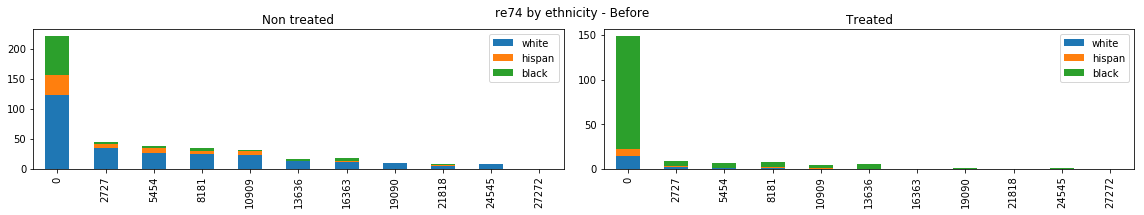

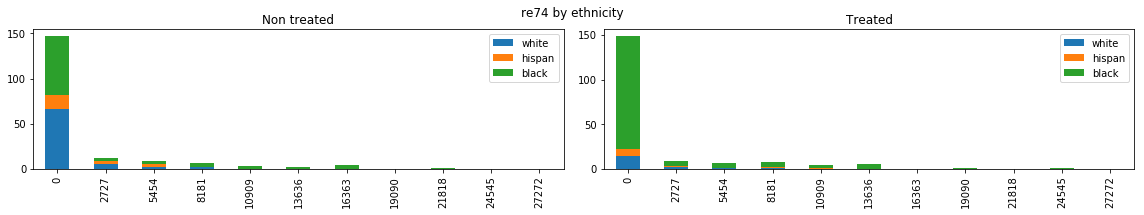

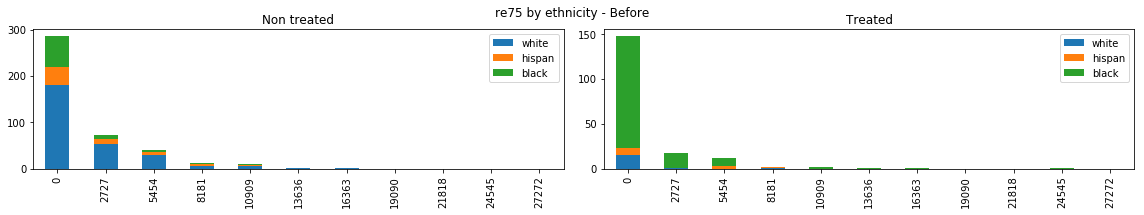

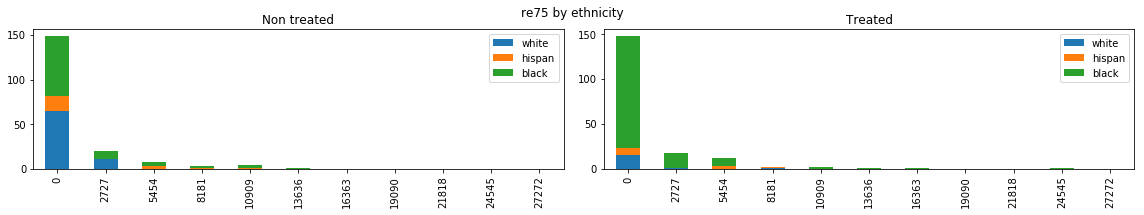

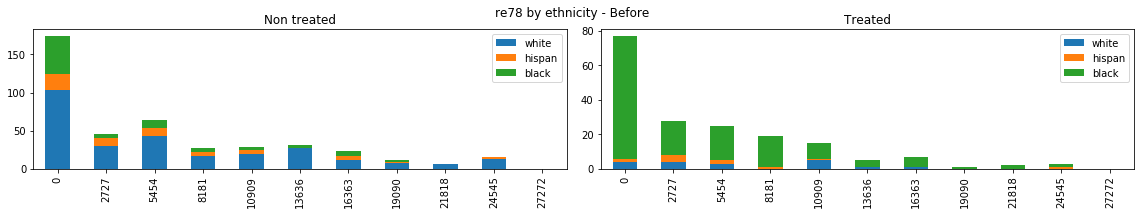

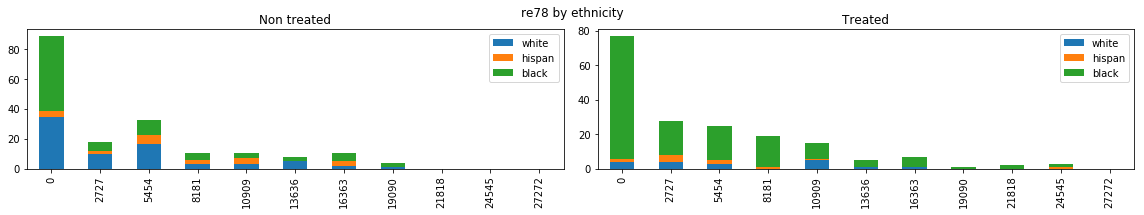

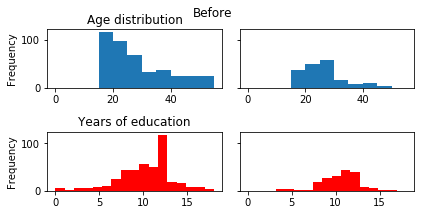

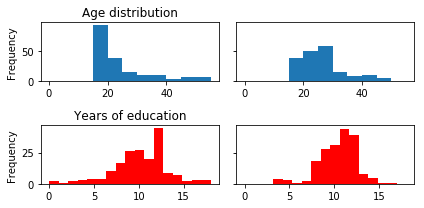

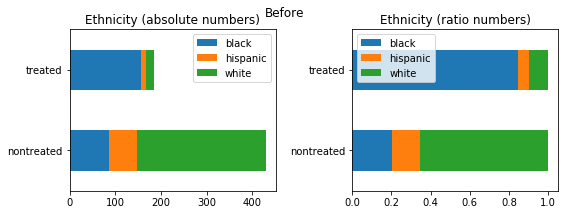

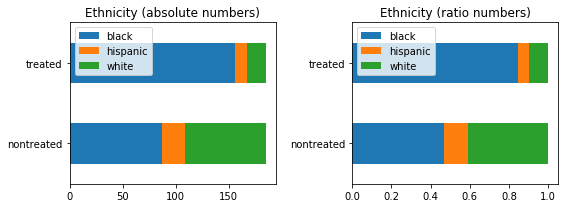

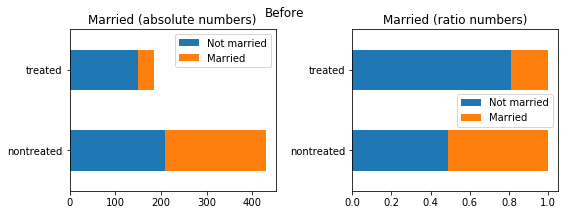

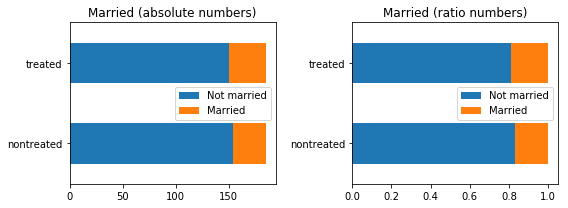

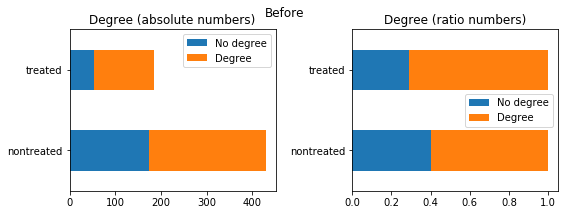

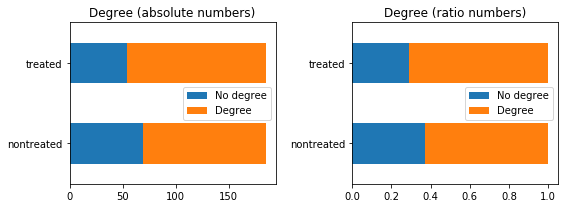

In [71]:
stats_about_dataset(treated_balanced, not_treated_balanced, treated, not_treated)

* For re variables, the white people are now less represented than before. It is explained because they are over represented in the treated group.
* The age distribution is still not similar
* but the years of education has become a bit more representative, except for the part in the non treated group where people have received no education.
* Ethnicity is still not the same but has progressed in the correct direction (more balanced)
* The mariage ratio has become almost identical
* The percent of ratio is still not identical but the gape is smaller (less than 10% difference)


### 1.5. Balancing the groups further

We choosed to edit the way the weight between node in the graph are computed by adding penalties. We don't want to take in account to much variables since it removes the meaning of the computation (why do propensity score computation if the metric we use at the end is completely different ?). We tried different and given the fact that the two groups still differ on - in our opinion - impactful variables that are years of education  and ethnicity. We choosed to apply

* a small penalty for age $| node_{1,education} - node_{2,education}|  * 0.01$ where the score is between 0 and 1
* a large penalty for ethnicity. We first tried to balance by adding penalty when the ethnicity did not match but since there is more black people in treated group than in the non treated group, it resulted in skewing other variable. Instead we want to remove this white over representation in our balance. So we apply a penalty if $node_{1,is\:white?} \neq node_{2,is\:white?}$

In [53]:
new_edges = list()

W = "white"
B = "black"
H = "hispan"
E = "educ"

for (i1, score1) in from_nodes:
    for (i2, score2) in to_nodes:
        x1 = lalonde_df.loc[i1]
        x2 = lalonde_df.loc[i2]
        
        #ethnicity_penalty = x1[W] != x2[W] or x1[B] != x2[B] or x1[H] != x2[H]
        ethnicity_penalty = x1[W] != x2[W]
        educ_penalty = abs(x1[E]- x2[E]) * 0.01
        penalty = 0.25 if ethnicity_penalty else 0
        penalty += educ_penalty
        new_edges.append((i1, i2, -(abs(score1 - score2)+penalty)))
        
        
G_new = nx.Graph()
G_new.add_nodes_from([label for (label, score) in from_nodes], bipartite=0)
G_new.add_nodes_from([label for (label, score) in to_nodes], bipartite=1)
G_new.add_weighted_edges_from(new_edges)

matching_new = nx.max_weight_matching(G_new, maxcardinality=True)

We then build a new dataframe with the new matching

In [54]:
new_df_to_append = list()

for id_, score in from_nodes:
    new_df_to_append.append(lalonde_df.loc[matching_new[id_]])
    
new_df_2 = pd.concat([treated.copy(), pd.DataFrame(new_df_to_append)])

assert len(new_df_2) == len(from_nodes) * 2

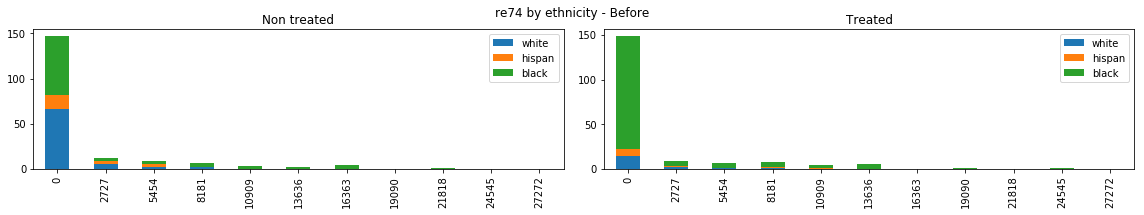

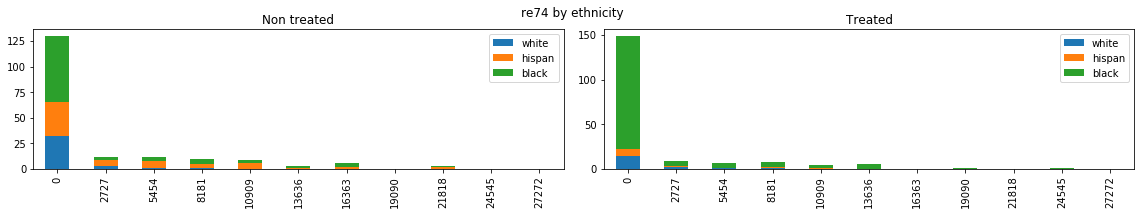

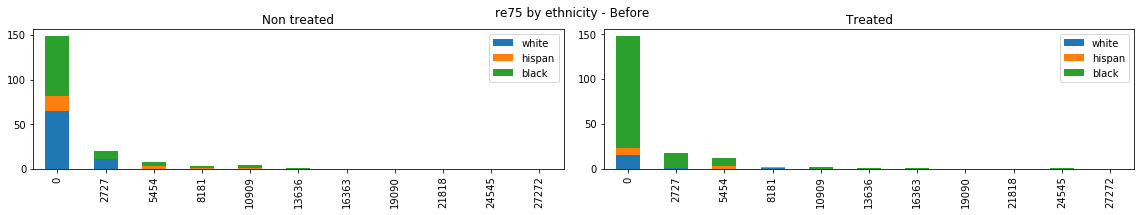

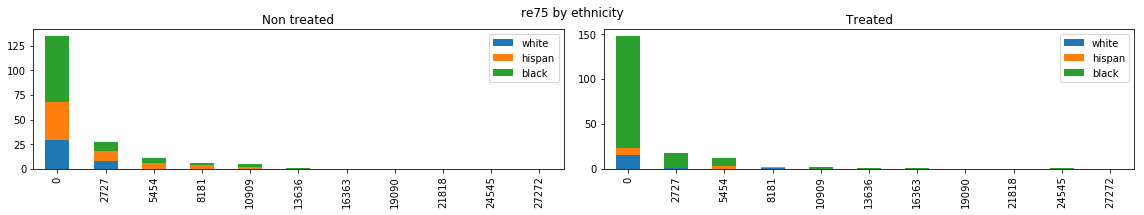

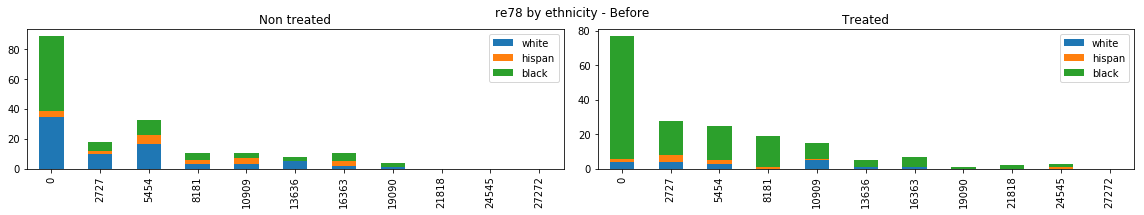

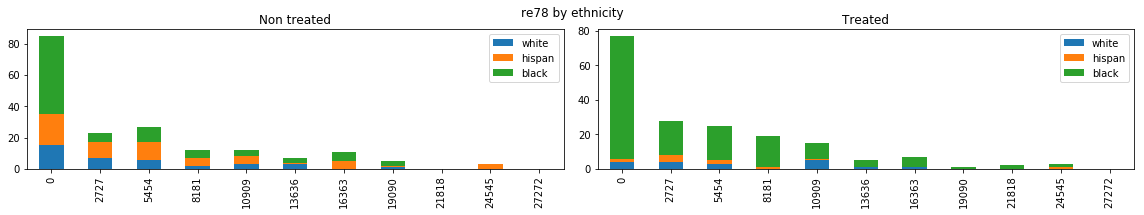

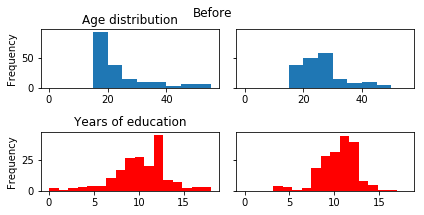

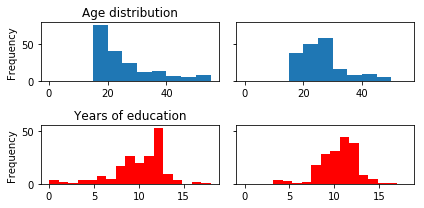

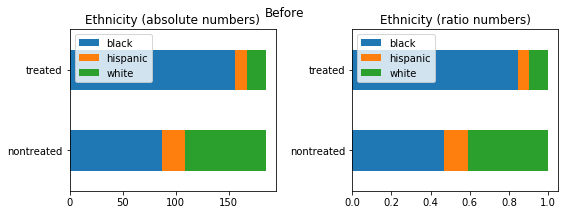

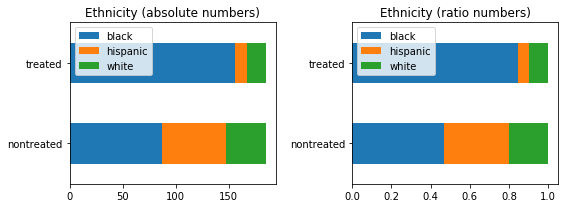

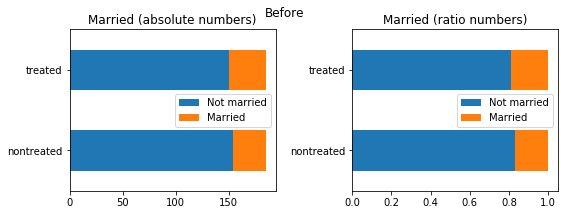

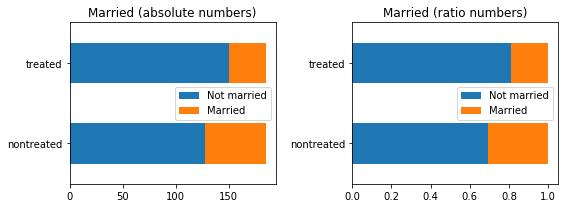

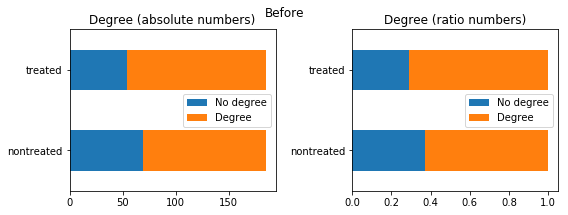

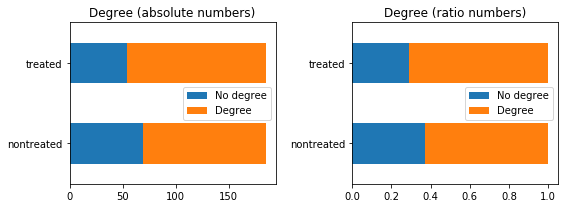

In [72]:
treated_new_2 = new_df_2[new_df_2["treat"] == 1]
nontreated_new_2 = new_df_2[new_df_2["treat"] == 0]

stats_about_dataset(treated_new_2, nontreated_new_2, treated_balanced, not_treated_balanced)

* year of education did not signifantly change in shape, but in amplitude
* ethnicity is now more diverse in the non treated group. One may argue that now the re* variables are less representative than before. In fact, as stated before, we're facing a situation we cannot solve(we cannot add more "not treated" black people in the dataset), so we thought it would be better to add more representativity
* other variables did not get significantly affected by our change

We are now more confident in our result and we now can state that the programm did not had significant effect. At least not as much we have predicted before. But is is hard to give an opinion without being able to balance more correctly the dataset. 

# Question 2

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)). [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

In [32]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from random import shuffle
from sklearn.metrics import confusion_matrix

### 1. Load the data and we separate targets and features: 

In [24]:
newsgroups_train = fetch_20newsgroups()
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)

X = vectorizer.fit_transform(newsgroups_train.data)
y = newsgroups_train.target

### 2. Split the set to 0.9 train data and 0.1 test data

In [25]:
n = len(y)
indices = list(range(n))
shuffle(indices)

test_len = round(0.1*n)
train_len = n - test_len

X_test = X[indices[0:test_len]]
y_test = y[indices[0:test_len]]

X_train = X[indices[test_len:n]]
y_train = y[indices[test_len:n]]

### 3. Cross validation with 0.1 validation data and 0.9 train data (from the remaining dataset) 

- The estimators are in range: [30, 70, 300] 
- The depths are in range: [100, 150, 200]

In order to visualise the results of the grid search we keep track of the different combinations of: 

- n_estimators
- max_depth 
- mean accuracy over 10-fold cross validation 

In [28]:
heatmap = np.zeros((3,3))

for i, n_estimators in enumerate([30, 70, 300]): 
    for j, max_depth in enumerate([100, 150, 200]): 
        print("n_estimators={}, max_depth={}".format(i, j))
        random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        scores = cross_val_score(random_forest, X_train, y_train, cv=10, n_jobs=-1)
        heatmap[i, j] = np.mean(scores)

n_estimators=0, max_depth=0
n_estimators=0, max_depth=1
n_estimators=0, max_depth=2
n_estimators=1, max_depth=0
n_estimators=1, max_depth=1
n_estimators=1, max_depth=2
n_estimators=2, max_depth=0
n_estimators=2, max_depth=1
n_estimators=2, max_depth=2


Here we show the heatmap for the accuracies obtained with different parameters. The vertical axis is the number of estimators, the horizontal axis is the max depth. 

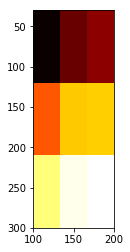

In [29]:
#fig = plt.figure()
#ax = Axes3D(fig)
#ax.scatter3D(x,y,z)
#plt.show()

plt.imshow(heatmap, cmap='hot', extent=[100, 200, 300, 30])
plt.show()

The best parameters to chose in this case are n_estimators=70 and max_depth=150 . We can see that the accuracy is increasing when these parameters are increased but the increased computing time is not worth the very small accuracy gain. 

In [30]:
random_forest = RandomForestClassifier(n_estimators=70, max_depth=150)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
y_pred = random_forest.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print(random_forest.score(X_test, y_test))

[[39  0  0  0  0  0  0  0  0  1  0  0  1  2  0  3  0  0  0  2]
 [ 0 34  1  2  0  2  1  0  0  0  0  0  1  0  0  1  0  0  1  0]
 [ 0  5 57  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  4 34  1  2  3  0  0  0  0  2  1  0  0  0  0  0  0  0]
 [ 0  3  2  1 48  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  3  1  0  0 51  1  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  1  1  2  2  0 55  1  1  0  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  2 57  2  0  0  0  3  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0 61  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 54  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 57  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  0  1  0  0  0  0  0 54  0  0  0  0  0  1  0  0]
 [ 1  2  1  3  2  1  1  2  0  0  0  1 46  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  2 50  1  0  2  0  1  0]
 [ 0  2  0  0  0  1  1  0  0  0  0  0  0  0 60  0  0  0  0  0]
 [ 0  2  0  1  0  0  0  1  0  0  0  0  2  1  0 58  0  0

In [41]:
indices = [i[0] for i in sorted(enumerate(random_forest.feature_importances_), key=lambda x:x[1])]
names_most = []
factor_most = []

names_less = []
factor_less = []

for r in range(1,20):
    names_most.append(vectorizer.get_feature_names()[indices[-r]])
    factor_most.append(len(np.nonzero(X[:, indices[-r]])[0]))
    
    names_less.append(vectorizer.get_feature_names()[indices[r]])
    factor_less.append(len(np.nonzero(X[:, indices[r]])[0]))

In [42]:
print(factor_most)
print(names_most)

[388, 491, 790, 277, 573, 278, 250, 337, 323, 187, 282, 266, 624, 497, 370, 215, 824, 422, 370]
['dod', 'sale', 'windows', 'bike', 'car', 'encryption', 'hockey', 'clipper', 'rutgers', 'nhl', 'baseball', 'cars', 'space', 'team', 'gun', 'israeli', 'god', 'graphics', 'apple']


in the previous cell we can see that the most important features are meaningful words that have non null TF-IDF in bigger number of doccuments compared to the less important features. 

In [43]:
print(factor_less)
print(names_less)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['000000', '00000000b', '00000001', '00000001b', '0000000667', '00000010', '00000010b', '00000011', '00000011b', '00000074', '00000093', '000000e5', '00000100', '00000100b', '00000101', '00000101b', '00000110', '00000110b', '00000111']
